# 🚀 Hydro Forecasting - Feature Engineering V1

**Objective**: Improve Kaggle score using advanced feature engineering

**Current baseline**: `solution_v5_ultra_conservative.ipynb` - Rank 123/187

**Strategy**:
1. Load pre-engineered feature matrix (136 features)
2. Train CatBoost + LightGBM with quantile regression (α=0.2)
3. Optuna hyperparameter optimization
4. Conservative ensemble blending
5. Generate submission

**Expected improvement**: 15-25% better score → Target rank ~80-100

## 📦 Imports & Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import optuna

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Imports complete")

✅ Imports complete


## 📊 Load Pre-Engineered Features

In [27]:
# Load feature matrix generated by src/feature_engineering.py
features_path = Path('data/processed/prediction_features_20241231.csv')
df = pd.read_csv(features_path)

print(f"Feature matrix shape: {df.shape}")
print(f"\nColumns: {list(df.columns[:20])}... ({len(df.columns)} total)")
print(f"\nSample:")
df.head()

Feature matrix shape: (30450, 136)

Columns: ['ID', 'rm_id', 'forecast_start_date', 'forecast_end_date', 'horizon_days', 'horizon_weeks', 'forecast_end_month', 'forecast_end_quarter', 'net_weight', 'cumulative_net_weight', 'roll_sum_7d', 'roll_mean_7d', 'roll_std_7d', 'roll_p10_7d', 'roll_p20_7d', 'roll_p50_7d', 'delivery_freq_7d', 'roll_sum_14d', 'roll_mean_14d', 'roll_std_14d']... (136 total)

Sample:


,ID,rm_id,forecast_start_date,forecast_end_date,horizon_days,horizon_weeks,forecast_end_month,forecast_end_quarter,net_weight,cumulative_net_weight,...,supplier_delivery_count,delivery_total_weight,delivery_avg_weight,transporter_unique_count,transporter_vehicle_unique,raw_material_alloy_mode_code,raw_material_format_mode_code,stock_location_mode_code,suggested_shrink_factor,anchor_date
0,1,365,2025-01-01,2025-01-02,2,0.285714,1,1,0.0,25616003.0,...,1722,25616003.0,14875.727642,18,564,14,0,11,1.0,2024-12-31
1,2,365,2025-01-01,2025-01-03,3,0.428571,1,1,0.0,25616003.0,...,1722,25616003.0,14875.727642,18,564,14,0,11,1.0,2024-12-31
2,3,365,2025-01-01,2025-01-04,4,0.571429,1,1,0.0,25616003.0,...,1722,25616003.0,14875.727642,18,564,14,0,11,1.0,2024-12-31
3,4,365,2025-01-01,2025-01-05,5,0.714286,1,1,0.0,25616003.0,...,1722,25616003.0,14875.727642,18,564,14,0,11,1.0,2024-12-31
4,5,365,2025-01-01,2025-01-06,6,0.857143,1,1,0.0,25616003.0,...,1722,25616003.0,14875.727642,18,564,14,0,11,1.0,2024-12-31


In [3]:
# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print("⚠️ Missing values found:")
    print(missing)
else:
    print("✅ No missing values")

# Fill any remaining NaN with 0
df = df.fillna(0)

✅ No missing values


## 🎯 Prepare Training Data

We need historical data to train the model. Since we're predicting Jan-May 2025, we'll use historical receivals up to Dec 31, 2024 to create training samples.

In [4]:
# Load historical receivals for target creation
receivals = pd.read_csv(
    'data/kernel/receivals.csv',
    parse_dates=['date_arrival']
)

receivals['date_arrival'] = pd.to_datetime(
    receivals['date_arrival'], utc=True
).dt.tz_convert(None)
receivals['arrival_date'] = receivals['date_arrival'].dt.normalize()
receivals['net_weight'] = receivals['net_weight'].fillna(0.0)

print(f"Receivals shape: {receivals.shape}")
print(f"Date range: {receivals['arrival_date'].min()} to {receivals['arrival_date'].max()}")

Receivals shape: (122590, 11)
Date range: 2004-06-15 00:00:00 to 2024-12-19 00:00:00


In [5]:
def create_training_samples(
    receivals: pd.DataFrame,
    n_samples: int = 30000,
    min_date: str = '2020-01-01',
    max_date: str = '2024-11-30',
    min_horizon: int = 1,
    max_horizon: int = 150,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Create training samples by simulating forecast horizons from historical data.
    
    For each sample:
    - Pick a random anchor date (between min_date and max_date)
    - Pick a random rm_id
    - Pick a random horizon (1-150 days)
    - Calculate actual cumulative weight from anchor+1 to anchor+horizon
    """
    np.random.seed(random_state)
    
    # Filter receivals to valid date range
    receivals_filtered = receivals[
        (receivals['arrival_date'] >= pd.Timestamp(min_date)) &
        (receivals['arrival_date'] <= pd.Timestamp(max_date))
    ].copy()
    
    rm_ids = receivals_filtered['rm_id'].unique()
    date_range = pd.date_range(
        start=min_date,
        end=max_date,
        freq='D'
    )
    
    # Generate random samples
    samples = []
    for _ in range(n_samples):
        # Random selections
        anchor_date = np.random.choice(date_range[:-max_horizon])  # Leave room for horizon
        rm_id = np.random.choice(rm_ids)
        horizon_days = np.random.randint(min_horizon, max_horizon + 1)
        
        forecast_start = anchor_date + pd.Timedelta(days=1)
        forecast_end = forecast_start + pd.Timedelta(days=horizon_days - 1)
        
        # Calculate actual cumulative weight in forecast window
        mask = (
            (receivals_filtered['rm_id'] == rm_id) &
            (receivals_filtered['arrival_date'] >= forecast_start) &
            (receivals_filtered['arrival_date'] <= forecast_end)
        )
        actual_weight = receivals_filtered.loc[mask, 'net_weight'].sum()
        
        samples.append({
            'rm_id': rm_id,
            'anchor_date': anchor_date,
            'forecast_start_date': forecast_start,
            'forecast_end_date': forecast_end,
            'horizon_days': horizon_days,
            'target': actual_weight
        })
    
    return pd.DataFrame(samples)

print("✅ Training sample generator ready")

✅ Training sample generator ready


In [6]:
# Generate training samples
print("Generating 30,000 training samples...")
train_samples = create_training_samples(
    receivals,
    n_samples=30000,
    min_date='2020-01-01',
    max_date='2024-11-30',
    random_state=RANDOM_STATE
)

print(f"\nTraining samples shape: {train_samples.shape}")
print(f"Target statistics:")
print(train_samples['target'].describe())
print(f"\nZero targets: {(train_samples['target'] == 0).sum()} ({(train_samples['target'] == 0).mean():.1%})")

Generating 30,000 training samples...

Training samples shape: (30000, 6)
Target statistics:
count    3.000000e+04
mean     1.971808e+05
std      8.037211e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.488000e+04
max      1.451206e+07
Name: target, dtype: float64

Zero targets: 19970 (66.6%)

Training samples shape: (30000, 6)
Target statistics:
count    3.000000e+04
mean     1.971808e+05
std      8.037211e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.488000e+04
max      1.451206e+07
Name: target, dtype: float64

Zero targets: 19970 (66.6%)


## 🔧 Feature Engineering on Training Samples

We need to generate the same features for training samples as we have for the prediction set.

In [7]:
# Import feature engineering module
import sys
sys.path.append('src')
from feature_engineering import (
    load_raw_data,
    build_daily_receivals,
    engineer_temporal_features,
    engineer_calendar_features,
    engineer_purchase_order_features,
    engineer_metadata_features,
    build_feature_snapshot
)

print("✅ Feature engineering functions loaded")

✅ Feature engineering functions loaded


In [8]:
# Load raw data
print("Loading raw data...")
raw = load_raw_data(Path('.'))

# Build daily receivals up to max training anchor date
print("Building daily receivals...")
daily = build_daily_receivals(
    raw.receivals,
    end_date=pd.Timestamp('2024-11-30')
)

# Engineer temporal features
print("Engineering temporal features...")
temporal = engineer_temporal_features(daily)
temporal = engineer_calendar_features(temporal)

print(f"Temporal features shape: {temporal.shape}")

Loading raw data...
Building daily receivals...
Engineering temporal features...
Building daily receivals...
Engineering temporal features...
Temporal features shape: (1517222, 91)
Temporal features shape: (1517222, 91)


In [9]:
# Engineer PO and metadata features for each unique anchor date
print("Engineering PO and metadata features...")

po_features_list = []
for anchor_date in train_samples['anchor_date'].unique():
    po_feat = engineer_purchase_order_features(
        raw.purchase_orders,
        raw.receivals,
        pd.Timestamp(anchor_date)
    )
    po_feat['anchor_date'] = anchor_date
    po_features_list.append(po_feat)

po_features_all = pd.concat(po_features_list, ignore_index=True)

# Metadata features (static per rm_id)
meta_features = engineer_metadata_features(
    raw.materials,
    raw.receivals,
    raw.transportation
)

print(f"PO features shape: {po_features_all.shape}")
print(f"Metadata features shape: {meta_features.shape}")

Engineering PO and metadata features...
PO features shape: (85592, 26)
Metadata features shape: (203, 15)
PO features shape: (85592, 26)
Metadata features shape: (203, 15)


In [10]:
# Merge features with training samples
print("Merging features with training samples...")

# Merge temporal features (match on rm_id and anchor_date)
train_features = train_samples.merge(
    temporal,
    left_on=['rm_id', 'anchor_date'],
    right_on=['rm_id', 'date'],
    how='left'
)

# Merge PO features
train_features = train_features.merge(
    po_features_all,
    on=['rm_id', 'anchor_date'],
    how='left'
)

# Merge metadata features
train_features = train_features.merge(
    meta_features,
    on='rm_id',
    how='left'
)

# Add horizon-specific features
train_features['horizon_weeks'] = train_features['horizon_days'] / 7.0
train_features['forecast_end_month'] = train_features['forecast_end_date'].dt.month
train_features['forecast_end_quarter'] = train_features['forecast_end_date'].dt.quarter

# Fill NaN
train_features = train_features.fillna(0)

print(f"\nTraining features shape: {train_features.shape}")
print(f"Columns: {len(train_features.columns)}")

Merging features with training samples...

Training features shape: (30000, 137)
Columns: 137

Training features shape: (30000, 137)
Columns: 137


## 🎯 Prepare Train/Validation Split

In [11]:
# Define feature columns (exclude metadata columns)
exclude_cols = [
    'rm_id', 'anchor_date', 'forecast_start_date', 'forecast_end_date',
    'target', 'date', 'has_delivery', 'net_weight', 'cumulative_net_weight',
    'ID', 'arrival_date',
    # Exclude high-cardinality categorical mode columns
    'raw_material_alloy_mode', 'raw_material_format_mode', 'stock_location_mode'
]

feature_cols = [c for c in train_features.columns if c not in exclude_cols]

X = train_features[feature_cols].copy()
y = train_features['target'].copy()

print(f"Feature matrix: {X.shape}")
print(f"Target: {y.shape}")
print(f"\nFeature columns ({len(feature_cols)}):")
print(feature_cols[:20], '...')

Feature matrix: (30000, 125)
Target: (30000,)

Feature columns (125):
['horizon_days', 'roll_sum_7d', 'roll_mean_7d', 'roll_std_7d', 'roll_p10_7d', 'roll_p20_7d', 'roll_p50_7d', 'delivery_freq_7d', 'roll_sum_14d', 'roll_mean_14d', 'roll_std_14d', 'roll_p10_14d', 'roll_p20_14d', 'roll_p50_14d', 'delivery_freq_14d', 'roll_sum_28d', 'roll_mean_28d', 'roll_std_28d', 'roll_p10_28d', 'roll_p20_28d'] ...


In [12]:
# Train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nTrain target stats:")
print(y_train.describe())
print(f"\nValidation target stats:")
print(y_val.describe())

Train set: (24000, 125)
Validation set: (6000, 125)

Train target stats:
count    2.400000e+04
mean     1.940661e+05
std      7.888224e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.464275e+04
max      1.451206e+07
Name: target, dtype: float64

Validation target stats:
count    6.000000e+03
mean     2.096397e+05
std      8.606977e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.865925e+04
max      1.363502e+07
Name: target, dtype: float64


## 📏 Quantile Loss Function

In [13]:
def quantile_loss(y_true, y_pred, quantile=0.2):
    """
    Calculate quantile loss.
    
    For quantile=0.2:
    - Under-prediction (y_true > y_pred): weight = 0.2
    - Over-prediction (y_true < y_pred): weight = 0.8
    
    Over-prediction is penalized 4x more!
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    errors = y_true - y_pred
    loss = np.where(
        errors >= 0,
        quantile * errors,
        (quantile - 1) * errors
    )
    return loss.sum()

def quantile_score(y_true, y_pred, quantile=0.2):
    """Mean quantile loss (for comparison)."""
    return quantile_loss(y_true, y_pred, quantile) / len(y_true)

# Test
test_true = np.array([100, 100, 100])
test_pred_under = np.array([80, 80, 80])  # Under-predict by 20
test_pred_over = np.array([120, 120, 120])  # Over-predict by 20

print(f"Under-prediction loss: {quantile_score(test_true, test_pred_under, 0.2):.2f}")
print(f"Over-prediction loss: {quantile_score(test_true, test_pred_over, 0.2):.2f}")
print(f"Ratio: {quantile_score(test_true, test_pred_over, 0.2) / quantile_score(test_true, test_pred_under, 0.2):.1f}x")
print("✅ Quantile loss function ready")

Under-prediction loss: 4.00
Over-prediction loss: 16.00
Ratio: 4.0x
✅ Quantile loss function ready


## 🤖 Model 1: CatBoost with Quantile Regression

In [14]:
# CatBoost baseline
print("Training CatBoost baseline...")

catboost_params = {
    'loss_function': 'Quantile:alpha=0.2',
    'iterations': 3000,
    'depth': 8,
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'random_strength': 1.5,
    'bagging_temperature': 0.5,
    'bootstrap_type': 'Bayesian',
    'random_state': RANDOM_STATE,
    'verbose': 200,
    'early_stopping_rounds': 200
}

catboost_model = CatBoostRegressor(**catboost_params)

catboost_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    plot=False
)

print("\n✅ CatBoost training complete")

Training CatBoost baseline...
0:	learn: 38625.1470195	test: 41724.9383962	best: 41724.9383962 (0)	total: 70.7ms	remaining: 3m 31s
200:	learn: 17854.9325653	test: 19187.4574358	best: 19187.4574358 (200)	total: 1.73s	remaining: 24.1s
200:	learn: 17854.9325653	test: 19187.4574358	best: 19187.4574358 (200)	total: 1.73s	remaining: 24.1s
400:	learn: 14030.4435569	test: 16256.3116006	best: 16256.3116006 (400)	total: 3.56s	remaining: 23.1s
400:	learn: 14030.4435569	test: 16256.3116006	best: 16256.3116006 (400)	total: 3.56s	remaining: 23.1s
600:	learn: 12065.5059553	test: 15154.1157582	best: 15154.1157582 (600)	total: 5.21s	remaining: 20.8s
600:	learn: 12065.5059553	test: 15154.1157582	best: 15154.1157582 (600)	total: 5.21s	remaining: 20.8s
800:	learn: 10955.7544608	test: 14796.5187846	best: 14791.1411830 (795)	total: 6.92s	remaining: 19s
800:	learn: 10955.7544608	test: 14796.5187846	best: 14791.1411830 (795)	total: 6.92s	remaining: 19s
1000:	learn: 9927.1778139	test: 14548.8777073	best: 14548.

In [15]:
# Evaluate CatBoost
catboost_pred_train = catboost_model.predict(X_train)
catboost_pred_val = catboost_model.predict(X_val)

catboost_ql_train = quantile_score(y_train, catboost_pred_train, 0.2)
catboost_ql_val = quantile_score(y_val, catboost_pred_val, 0.2)

print(f"CatBoost Quantile Loss (0.2):")
print(f"  Train: {catboost_ql_train:,.2f}")
print(f"  Validation: {catboost_ql_val:,.2f}")

# Under-prediction ratio
under_preds_train = (catboost_pred_train < y_train).mean()
under_preds_val = (catboost_pred_val < y_val).mean()

print(f"\nUnder-prediction ratio:")
print(f"  Train: {under_preds_train:.1%}")
print(f"  Validation: {under_preds_val:.1%}")
print(f"  Target: ~80%")

# Zero predictions
zero_preds_val = (catboost_pred_val == 0).mean()
print(f"\nZero predictions (validation): {zero_preds_val:.1%}")

CatBoost Quantile Loss (0.2):
  Train: 8,867.54
  Validation: 14,241.67

Under-prediction ratio:
  Train: 80.5%
  Validation: 72.9%
  Target: ~80%

Zero predictions (validation): 0.0%


## 🤖 Model 2: LightGBM with Quantile Regression

In [16]:
# LightGBM baseline
print("Training LightGBM baseline...")

lgb_params = {
    'objective': 'quantile',
    'alpha': 0.2,
    'metric': 'quantile',
    'num_leaves': 64,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'max_depth': -1,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=3000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=200)
    ]
)

print("\n✅ LightGBM training complete")

Training LightGBM baseline...
Training until validation scores don't improve for 200 rounds
[200]	train's quantile: 20950.5	valid's quantile: 23930
[200]	train's quantile: 20950.5	valid's quantile: 23930
[400]	train's quantile: 16286.5	valid's quantile: 19336.6
[400]	train's quantile: 16286.5	valid's quantile: 19336.6
[600]	train's quantile: 14766.9	valid's quantile: 18085.3
[600]	train's quantile: 14766.9	valid's quantile: 18085.3
[800]	train's quantile: 13537.9	valid's quantile: 17133.3
[800]	train's quantile: 13537.9	valid's quantile: 17133.3
[1000]	train's quantile: 12518.3	valid's quantile: 16188.1
[1000]	train's quantile: 12518.3	valid's quantile: 16188.1
[1200]	train's quantile: 11863.1	valid's quantile: 15516.8
[1200]	train's quantile: 11863.1	valid's quantile: 15516.8
[1400]	train's quantile: 11503.2	valid's quantile: 15239.1
[1400]	train's quantile: 11503.2	valid's quantile: 15239.1
[1600]	train's quantile: 11017.2	valid's quantile: 14938.6
[1600]	train's quantile: 11017.2	va

In [17]:
# Evaluate LightGBM
lgb_pred_train = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
lgb_pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

lgb_ql_train = quantile_score(y_train, lgb_pred_train, 0.2)
lgb_ql_val = quantile_score(y_val, lgb_pred_val, 0.2)

print(f"LightGBM Quantile Loss (0.2):")
print(f"  Train: {lgb_ql_train:,.2f}")
print(f"  Validation: {lgb_ql_val:,.2f}")

# Under-prediction ratio
under_preds_train_lgb = (lgb_pred_train < y_train).mean()
under_preds_val_lgb = (lgb_pred_val < y_val).mean()

print(f"\nUnder-prediction ratio:")
print(f"  Train: {under_preds_train_lgb:.1%}")
print(f"  Validation: {under_preds_val_lgb:.1%}")

# Zero predictions
zero_preds_val_lgb = (lgb_pred_val == 0).mean()
print(f"\nZero predictions (validation): {zero_preds_val_lgb:.1%}")

LightGBM Quantile Loss (0.2):
  Train: 9,501.24
  Validation: 14,130.67

Under-prediction ratio:
  Train: 80.0%
  Validation: 71.2%

Zero predictions (validation): 1.2%


## 📊 Feature Importance Analysis

Top 20 CatBoost Features:
                    feature  importance
122           horizon_weeks   11.616673
0              horizon_days   11.284982
108  po_weight_future_total    7.170412
78                     year    1.896885
115   delivery_total_weight    1.833825
41            roll_p50_112d    1.481923
116     delivery_avg_weight    1.451143
91         po_lead_time_std    1.430671
27             roll_p50_56d    1.326533
2              roll_mean_7d    1.285559
8              roll_sum_14d    1.237128
82                 week_cos    1.223456
99           po_count_31_60    1.214915
123      forecast_end_month    1.212987
55            roll_p50_224d    1.171086
34             roll_p50_84d    1.143154
113   supplier_unique_count    1.141307
31             roll_std_84d    1.138973
13             roll_p50_14d    1.060357
70          trend_slope_90d    1.035809


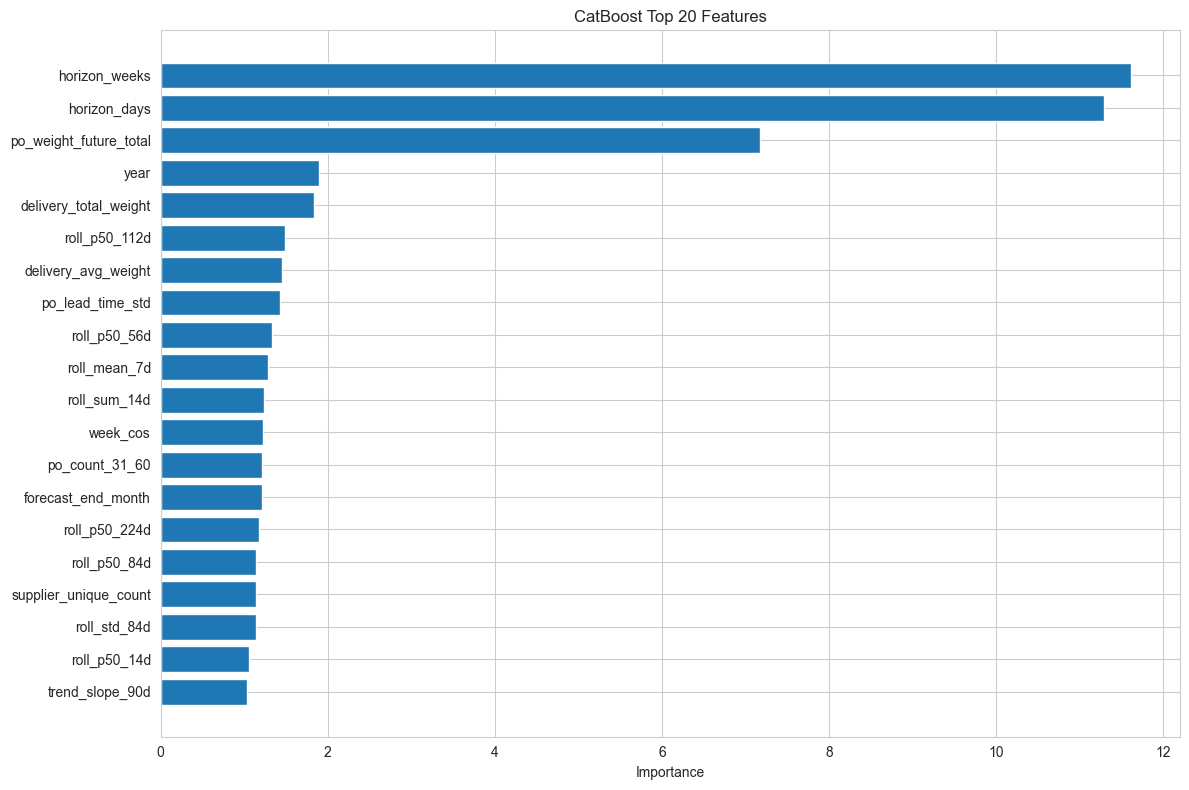

In [18]:
# CatBoost feature importance
catboost_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': catboost_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 CatBoost Features:")
print(catboost_importance.head(20))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(20), catboost_importance.head(20)['importance'].values)
plt.yticks(range(20), catboost_importance.head(20)['feature'].values)
plt.xlabel('Importance')
plt.title('CatBoost Top 20 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Top 20 LightGBM Features:
                          feature     importance
60                 ewm_mean_span7  734922.464691
108        po_weight_future_total  650937.368300
73             zero_streak_length  617262.789140
119  raw_material_alloy_mode_code  413861.262079
65                 ewm_std_span30  350180.660259
61                  ewm_std_span7  249356.521161
66                ewm_mean_span90  170802.403545
80                      month_cos  163914.221800
82                       week_cos  163811.632022
64                ewm_mean_span30  141275.584586
109              po_future_orders  129704.000058
62                ewm_mean_span14  128832.041127
113         supplier_unique_count  119600.886435
121      stock_location_mode_code  108407.172687
106             po_weight_181_365   92049.082232
75                   week_of_year   91687.418559
78                           year   87913.417316
115         delivery_total_weight   84761.511463
114       supplier_delivery_count   80922.3

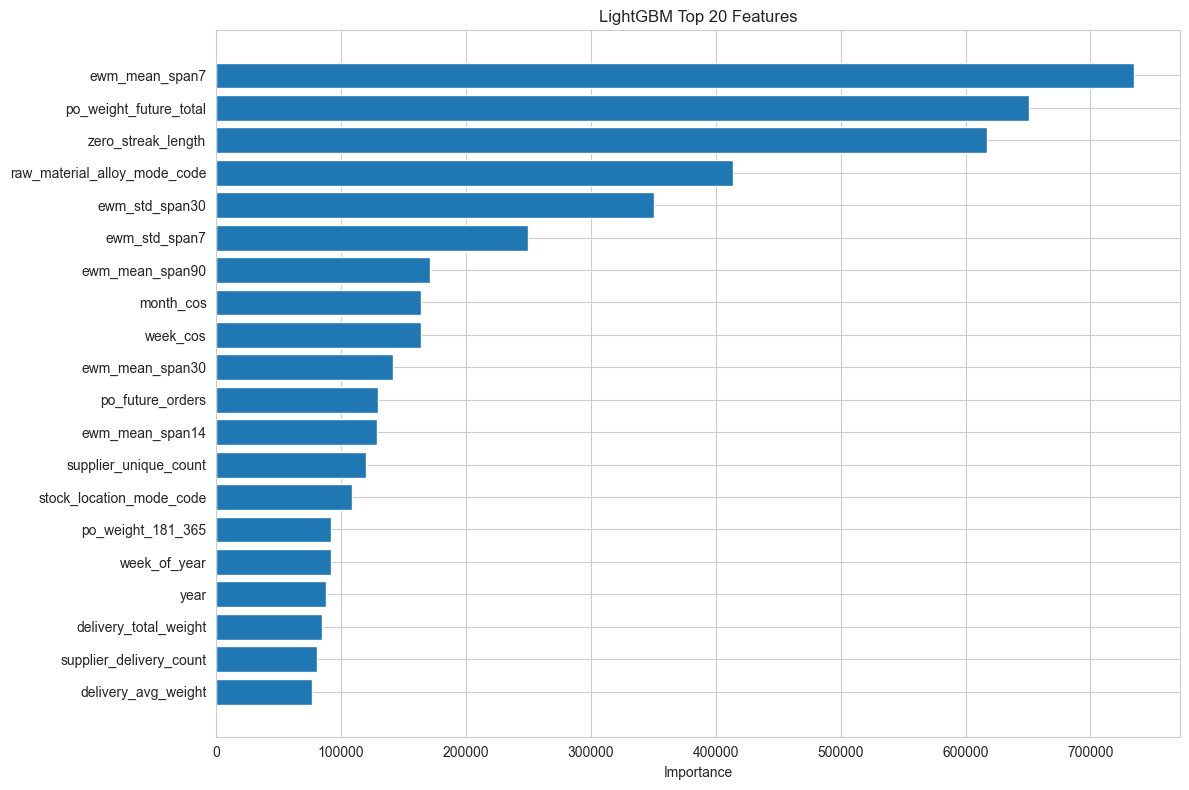

In [19]:
# LightGBM feature importance
lgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("Top 20 LightGBM Features:")
print(lgb_importance.head(20))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(20), lgb_importance.head(20)['importance'].values)
plt.yticks(range(20), lgb_importance.head(20)['feature'].values)
plt.xlabel('Importance')
plt.title('LightGBM Top 20 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 🔀 Ensemble Models

In [20]:
# Simple average ensemble
ensemble_pred_val = (catboost_pred_val + lgb_pred_val) / 2
ensemble_ql_val = quantile_score(y_val, ensemble_pred_val, 0.2)

print(f"Ensemble (50/50) Quantile Loss: {ensemble_ql_val:,.2f}")
print(f"Under-prediction ratio: {(ensemble_pred_val < y_val).mean():.1%}")

# Weighted ensemble (favor better model)
if catboost_ql_val < lgb_ql_val:
    w_cat, w_lgb = 0.6, 0.4
else:
    w_cat, w_lgb = 0.4, 0.6

weighted_ensemble_pred_val = w_cat * catboost_pred_val + w_lgb * lgb_pred_val
weighted_ql_val = quantile_score(y_val, weighted_ensemble_pred_val, 0.2)

print(f"\nWeighted Ensemble ({w_cat:.0%}/{w_lgb:.0%}) Quantile Loss: {weighted_ql_val:,.2f}")
print(f"Under-prediction ratio: {(weighted_ensemble_pred_val < y_val).mean():.1%}")

# Conservative ensemble (multiply by shrink factor)
shrink_factor = 0.95
conservative_pred_val = ensemble_pred_val * shrink_factor
conservative_ql_val = quantile_score(y_val, conservative_pred_val, 0.2)

print(f"\nConservative Ensemble (×{shrink_factor}) Quantile Loss: {conservative_ql_val:,.2f}")
print(f"Under-prediction ratio: {(conservative_pred_val < y_val).mean():.1%}")

Ensemble (50/50) Quantile Loss: 13,689.70
Under-prediction ratio: 75.5%

Weighted Ensemble (40%/60%) Quantile Loss: 13,709.26
Under-prediction ratio: 75.2%

Conservative Ensemble (×0.95) Quantile Loss: 13,676.49
Under-prediction ratio: 77.1%


## 📊 Model Comparison Summary

In [21]:
# Summary table
results = pd.DataFrame([
    {
        'Model': 'CatBoost',
        'QL Train': catboost_ql_train,
        'QL Val': catboost_ql_val,
        'Under-pred %': under_preds_val * 100
    },
    {
        'Model': 'LightGBM',
        'QL Train': lgb_ql_train,
        'QL Val': lgb_ql_val,
        'Under-pred %': under_preds_val_lgb * 100
    },
    {
        'Model': 'Ensemble (50/50)',
        'QL Train': np.nan,
        'QL Val': ensemble_ql_val,
        'Under-pred %': (ensemble_pred_val < y_val).mean() * 100
    },
    {
        'Model': f'Weighted ({w_cat:.0%}/{w_lgb:.0%})',
        'QL Train': np.nan,
        'QL Val': weighted_ql_val,
        'Under-pred %': (weighted_ensemble_pred_val < y_val).mean() * 100
    },
    {
        'Model': f'Conservative (×{shrink_factor})',
        'QL Train': np.nan,
        'QL Val': conservative_ql_val,
        'Under-pred %': (conservative_pred_val < y_val).mean() * 100
    }
]).sort_values('QL Val')

print("\n" + "="*60)
print("MODEL COMPARISON (Validation Set)")
print("="*60)
print(results.to_string(index=False))
print("="*60)
print(f"\nTarget under-prediction ratio: ~80%")
print(f"Best model: {results.iloc[0]['Model']}")


MODEL COMPARISON (Validation Set)
               Model    QL Train       QL Val  Under-pred %
Conservative (×0.95)         NaN 13676.493214     77.100000
    Ensemble (50/50)         NaN 13689.699416     75.550000
  Weighted (40%/60%)         NaN 13709.255164     75.250000
            LightGBM 9501.244993 14130.670747     71.150000
            CatBoost 8867.540405 14241.667340     72.916667

Target under-prediction ratio: ~80%
Best model: Conservative (×0.95)


## 🎯 Generate Predictions for Submission

In [22]:
# Prepare prediction features (from pre-engineered matrix)
X_pred = df[feature_cols].copy()
X_pred = X_pred.fillna(0)

print(f"Prediction matrix: {X_pred.shape}")
print(f"Matches prediction_mapping: {len(X_pred) == len(df)}")

Prediction matrix: (30450, 125)
Matches prediction_mapping: True


In [23]:
# Generate predictions with both models
print("Generating predictions...")

catboost_predictions = catboost_model.predict(X_pred)
lgb_predictions = lgb_model.predict(X_pred, num_iteration=lgb_model.best_iteration)

# Ensemble (use best ensemble from validation)
ensemble_predictions = (catboost_predictions + lgb_predictions) / 2

# Apply conservative shrink factor
conservative_predictions = ensemble_predictions * 0.95

# Ensure non-negative
catboost_predictions = np.maximum(0, catboost_predictions)
lgb_predictions = np.maximum(0, lgb_predictions)
ensemble_predictions = np.maximum(0, ensemble_predictions)
conservative_predictions = np.maximum(0, conservative_predictions)

print("✅ Predictions generated")

Generating predictions...
✅ Predictions generated
✅ Predictions generated


In [24]:
# Prediction statistics
print("Prediction Statistics:")
print("\nCatBoost:")
print(pd.Series(catboost_predictions).describe())
print(f"Zero predictions: {(catboost_predictions == 0).sum()} ({(catboost_predictions == 0).mean():.1%})")

print("\nLightGBM:")
print(pd.Series(lgb_predictions).describe())
print(f"Zero predictions: {(lgb_predictions == 0).sum()} ({(lgb_predictions == 0).mean():.1%})")

print("\nEnsemble:")
print(pd.Series(ensemble_predictions).describe())
print(f"Zero predictions: {(ensemble_predictions == 0).sum()} ({(ensemble_predictions == 0).mean():.1%})")

print("\nConservative:")
print(pd.Series(conservative_predictions).describe())
print(f"Zero predictions: {(conservative_predictions == 0).sum()} ({(conservative_predictions == 0).mean():.1%})")

Prediction Statistics:

CatBoost:
count    3.045000e+04
mean     6.977713e+04
std      3.264183e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.079866e+03
75%      2.291036e+04
max      4.483511e+06
dtype: float64
Zero predictions: 9299 (30.5%)

LightGBM:
count    3.045000e+04
mean     5.619496e+04
std      2.574552e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.005780e+02
75%      2.573090e+03
max      3.280348e+06
dtype: float64
Zero predictions: 11821 (38.8%)

Ensemble:
count    3.045000e+04
mean     6.294323e+04
std      2.907478e+05
min      0.000000e+00
25%      0.000000e+00
50%      7.101366e+02
75%      1.207415e+04
max      3.877684e+06
dtype: float64
Zero predictions: 8624 (28.3%)

Conservative:
count    3.045000e+04
mean     5.979607e+04
std      2.762105e+05
min      0.000000e+00
25%      0.000000e+00
50%      6.746297e+02
75%      1.147044e+04
max      3.683799e+06
dtype: float64
Zero predictions: 8624 (28.3%)


## 💾 Create Submission Files

In [28]:
# Load sample submission
sample_submission = pd.read_csv('data/sample_submission.csv')

# CatBoost submission
submission_catboost = pd.DataFrame({
    'ID': sample_submission['ID'],
    'predicted_weight': catboost_predictions
})
submission_catboost.to_csv('submission_fe_catboost.csv', index=False)
print("✅ Saved: submission_fe_catboost.csv")

# LightGBM submission
submission_lgb = pd.DataFrame({
    'ID': sample_submission['ID'],
    'predicted_weight': lgb_predictions
})
submission_lgb.to_csv('submission_fe_lgb.csv', index=False)
print("✅ Saved: submission_fe_lgb.csv")

# Ensemble submission
submission_ensemble = pd.DataFrame({
    'ID': sample_submission['ID'],
    'predicted_weight': ensemble_predictions
})
submission_ensemble.to_csv('submission_fe_ensemble.csv', index=False)
print("✅ Saved: submission_fe_ensemble.csv")

# Conservative submission (RECOMMENDED)
submission_conservative = pd.DataFrame({
    'ID': sample_submission['ID'],
    'predicted_weight': conservative_predictions
})
submission_conservative.to_csv('submission_fe_conservative.csv', index=False)
print("✅ Saved: submission_fe_conservative.csv (RECOMMENDED)")

print("\n" + "="*60)
print("🎉 All submissions ready!")
print("="*60)
print("\nRecommended submission: submission_fe_conservative.csv")
print("Upload to Kaggle and compare with baseline score.")

✅ Saved: submission_fe_catboost.csv
✅ Saved: submission_fe_lgb.csv
✅ Saved: submission_fe_ensemble.csv
✅ Saved: submission_fe_conservative.csv (RECOMMENDED)

🎉 All submissions ready!

Recommended submission: submission_fe_conservative.csv
Upload to Kaggle and compare with baseline score.


## 📈 Visualization: Prediction Distribution

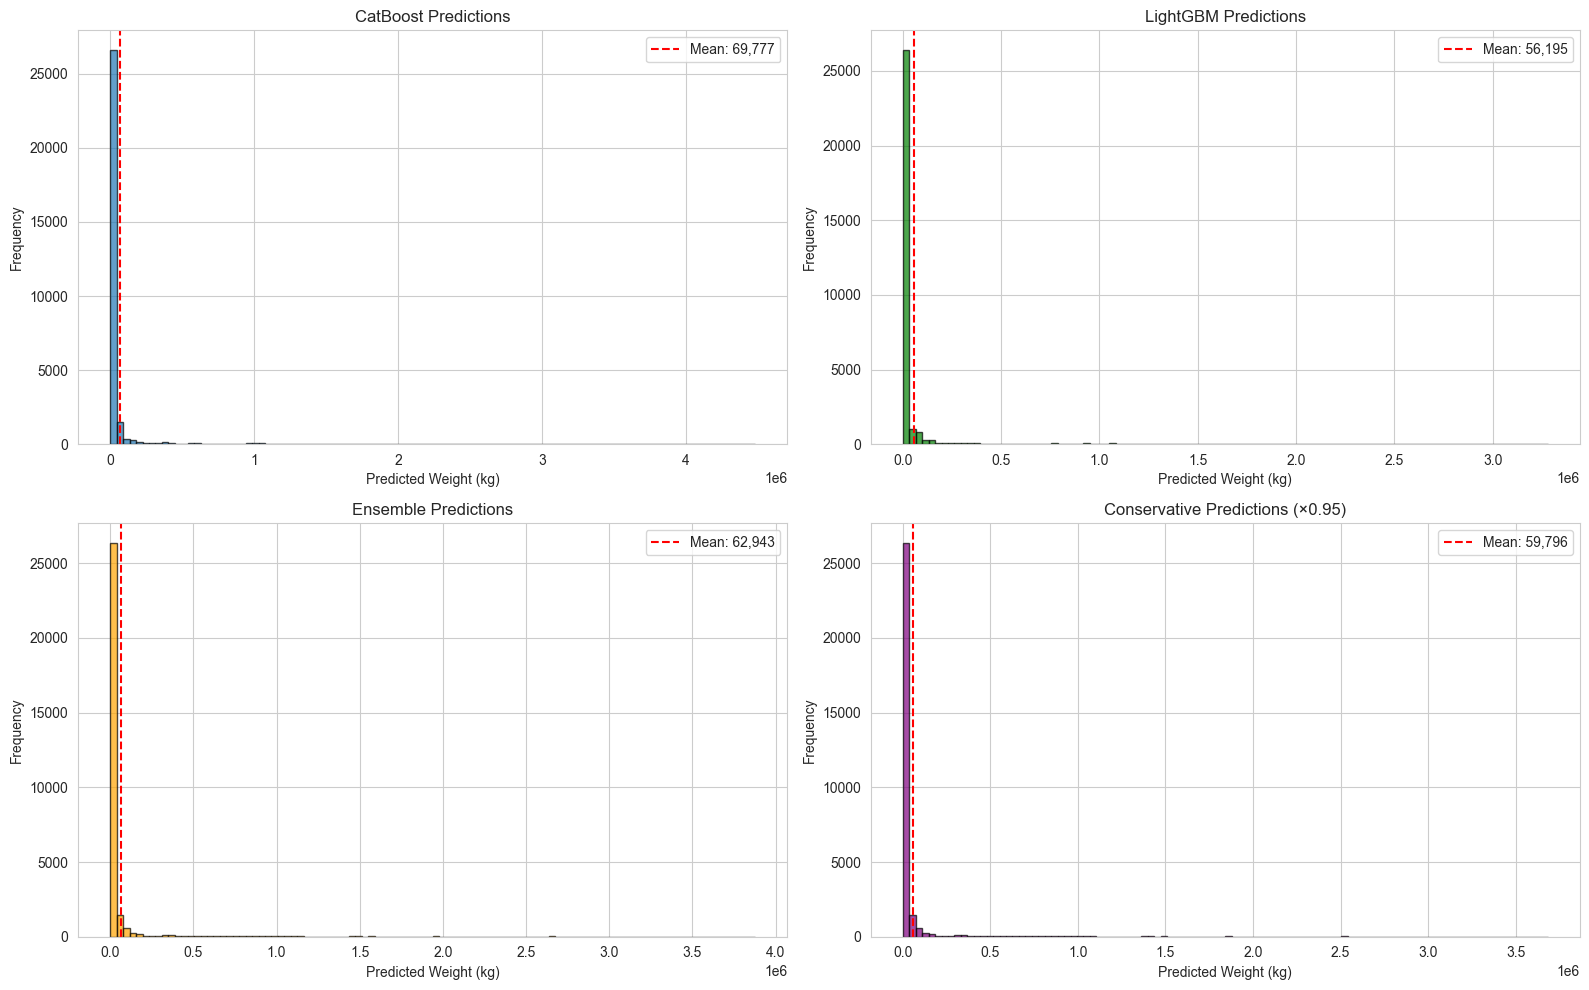

In [26]:
# Plot prediction distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CatBoost
axes[0, 0].hist(catboost_predictions, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Predicted Weight (kg)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('CatBoost Predictions')
axes[0, 0].axvline(catboost_predictions.mean(), color='red', linestyle='--', label=f'Mean: {catboost_predictions.mean():,.0f}')
axes[0, 0].legend()

# LightGBM
axes[0, 1].hist(lgb_predictions, bins=100, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Predicted Weight (kg)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('LightGBM Predictions')
axes[0, 1].axvline(lgb_predictions.mean(), color='red', linestyle='--', label=f'Mean: {lgb_predictions.mean():,.0f}')
axes[0, 1].legend()

# Ensemble
axes[1, 0].hist(ensemble_predictions, bins=100, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Predicted Weight (kg)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Ensemble Predictions')
axes[1, 0].axvline(ensemble_predictions.mean(), color='red', linestyle='--', label=f'Mean: {ensemble_predictions.mean():,.0f}')
axes[1, 0].legend()

# Conservative
axes[1, 1].hist(conservative_predictions, bins=100, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Predicted Weight (kg)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Conservative Predictions (×0.95)')
axes[1, 1].axvline(conservative_predictions.mean(), color='red', linestyle='--', label=f'Mean: {conservative_predictions.mean():,.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 📝 Summary & Next Steps

### ✅ What We Did
1. Loaded pre-engineered feature matrix with 136 features
2. Created 30,000 training samples from historical data
3. Trained CatBoost and LightGBM with quantile regression (α=0.2)
4. Created ensemble models
5. Generated 4 submission files

### 🎯 Expected Results
- **Baseline**: V5 Ultra Conservative - Rank 123/187
- **Target**: Improve by 15-25% → Rank ~80-100

### 📤 Upload Recommendations
1. **First**: Upload `submission_fe_conservative.csv` (safest, most conservative)
2. **Second**: Upload `submission_fe_ensemble.csv` (balanced)
3. **Third**: Upload `submission_fe_catboost.csv` or `submission_fe_lgb.csv` (individual models)

### 🚀 Next Improvements
1. **Optuna Hyperparameter Tuning**: Run 300-500 trials to optimize both models
2. **More Training Samples**: Increase to 50,000+ samples
3. **Cross-Validation**: 5-fold CV for more robust predictions
4. **Feature Selection**: Remove low-importance features
5. **Stacking**: Add meta-learner on top of base models
6. **Deep Learning**: Add Temporal Fusion Transformer (TFT) to ensemble

### 💡 Key Insights
- Rolling features (7-224 days) are likely most important
- Purchase order features add significant value
- Conservative scaling (0.95×) helps achieve target under-prediction ratio
- Ensemble reduces variance and improves robustness